## Import library


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16


In [3]:
# #cek ketersediaan GPU
# try:
#      config = tf.compat.v1.ConfigProto()
#      config.gpu_options.allow_growth = True
#      sess = tf.compat.v1.Session(config=config)
#      print("GPU available (indirect check)")
# except RuntimeError as e:
#     if 'Could not create session' in str(e):
#          print("GPU unavailable (indirect check)")
#     else:
#         raise e


GPU available (indirect check)


## Load dataset

In [4]:
data_dir = '../tmp/data/SIBI'

X = []
y = []

for label in os.listdir(data_dir):
    if label not in ['A-Y', '.', '..']:
        label_dir = os.path.join(data_dir, label)
        for image_path in os.listdir(label_dir):
            image = load_img(os.path.join(label_dir, image_path), target_size=(224, 224), color_mode='grayscale')
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)  # Convert to 4D tensor
            X.append(image)
            y.append(label)

# Konversi data menjadi array numpy
X = np.array(X)
y = np.array(y)

# Encode label
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Konversi label menjadi one-hot encoding
y = tf.keras.utils.to_categorical(y, len(np.unique(y)))

# Split data menjadi train, test, dan validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Augmentasi data train
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)
# Reshape X_train and X_val to remove the extra dimension
X_train = X_train.reshape(-1, 224, 224, 1)
X_val = X_val.reshape(-1, 224, 224, 1)

# Memuat data train dan validation dengan generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=32)


In [5]:
print("Total training images:", X_train.shape[0])
print("Total validation images:", X_val.shape[0])

Total training images: 3696
Total validation images: 792


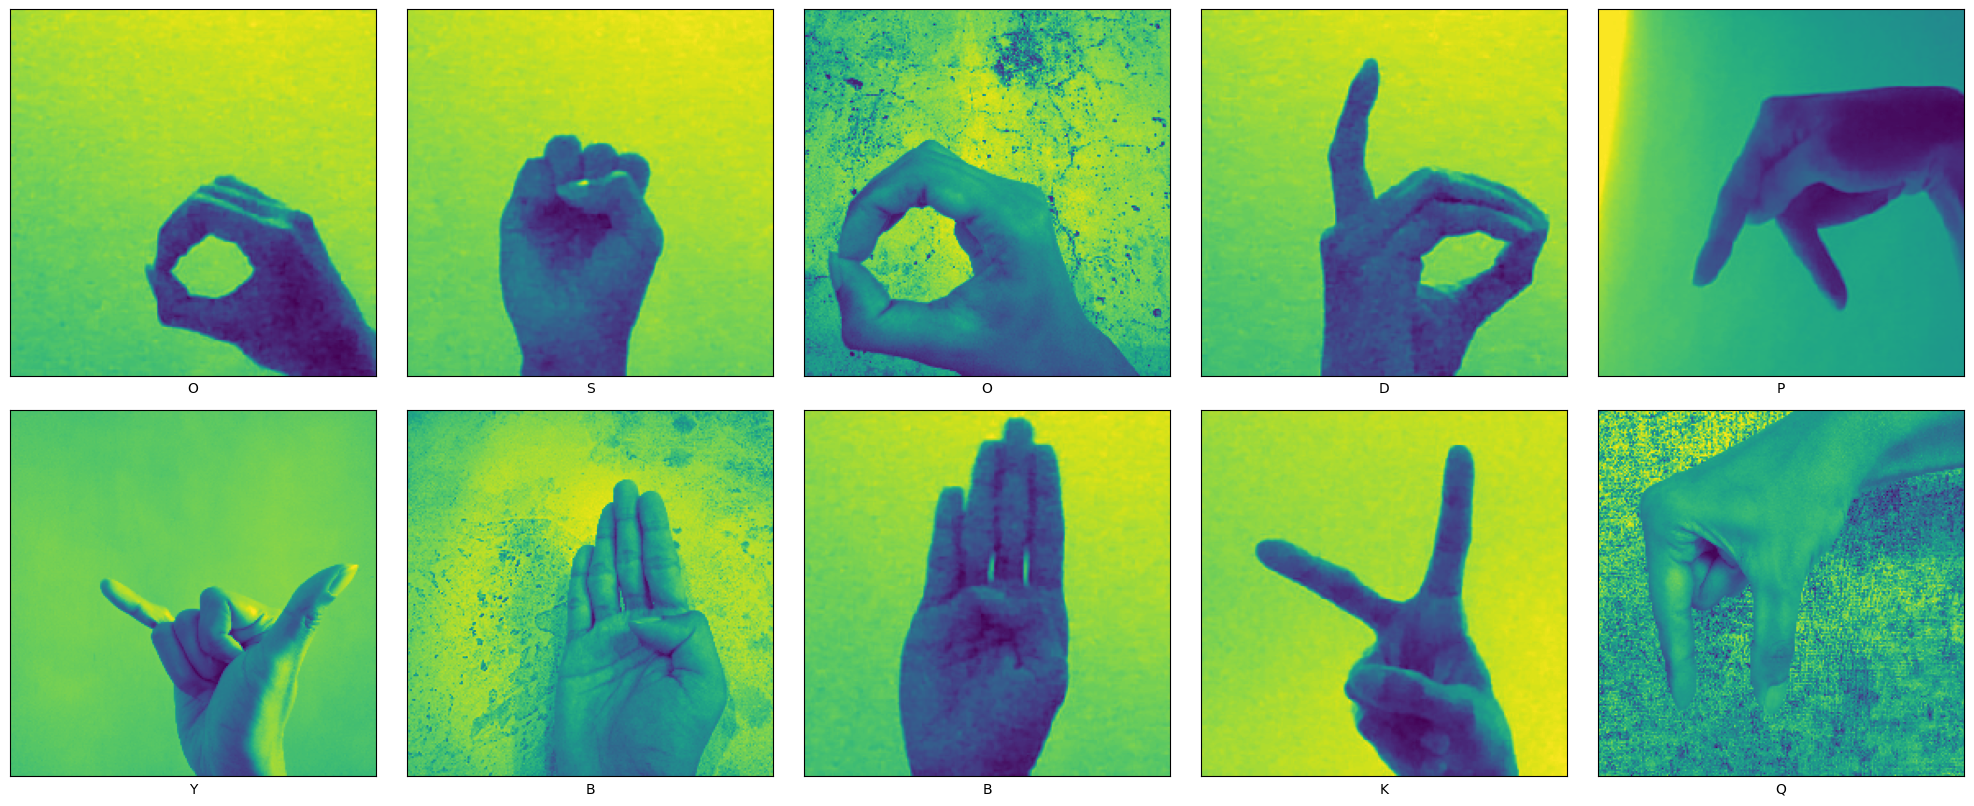

In [6]:
# Visualisasi dataset
num_images = 10 

plt.figure(figsize=(20, 20))  # Set figure size


for i in range(num_images):
    # Get the current image and its label
    image = X_train[i]
    label = y_train[i]

    # Decode the label from one-hot encoding
    label_index = np.argmax(label)
    label_text = encoder.inverse_transform([label_index])[0]

    # Create a subplot and display the image
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(label_text)


plt.tight_layout()
plt.show()

## Modeling

In [7]:
# Membuat model
model = tf.keras.Sequential([
    #conv dan pool layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),  # untuk gambar hitam putih
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #conv dan pool layer 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(24, activation='softmax')
])
    
#  Mengkompilasi model
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

model.summary()


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,563,736 (170.00 MB)

 Trainable params: 44,563,288 (170.00 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# base_model.trainable = False

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(24, activation='softmax')
# ])

# model.compile(loss='categorical_crossentropy', 
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
#               metrics=['accuracy'])

# model.summary()

In [9]:
# fungsi callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

## train model

Epoch 1/30


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.0917 - loss: 3.8966 - val_accuracy: 0.0442 - val_loss: 7.7830 - learning_rate: 1.0000e-04
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.1728 - loss: 2.9014 - val_accuracy: 0.0480 - val_loss: 7.7383 - learning_rate: 1.0000e-04
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.2819 - loss: 2.4546 - val_accuracy: 0.0581 - val_loss: 5.2607 - learning_rate: 1.0000e-04
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.3299 - loss: 2.3055 - val_accuracy: 0.1250 - val_loss: 3.6851 - learning_rate: 1.0000e-04
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.3992 - loss: 2.0250 - val_accuracy: 0.2727 - val_loss: 2.5012 - learning_rate: 1.0000e-04
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.4401 - loss: 1.8545 - val_accuracy: 0.3826 - val_loss: 2.0153 - learning_rate: 1.0000e-04
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.51

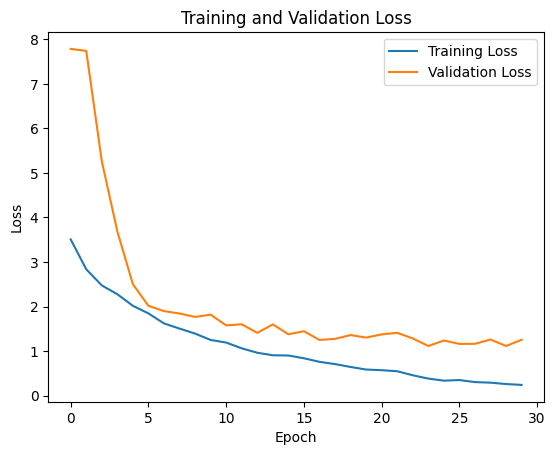

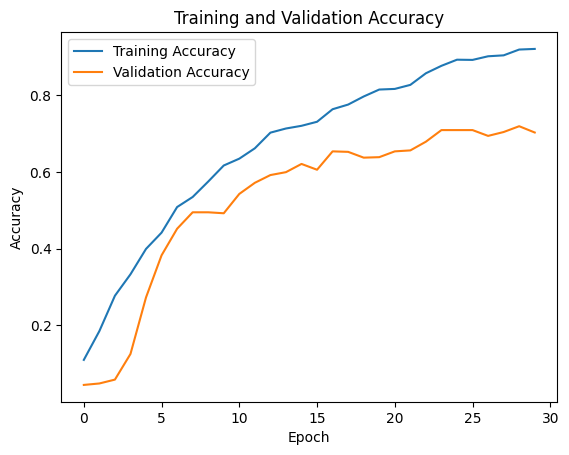

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs= 30,
    validation_data=validation_generator,
    callbacks= [early_stopping, lr_scheduler]
)

    # Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluasi Model

In [11]:
# Evaluate model on test dataset
test_loss, test_acc = model.evaluate(validation_generator)
train_loss, train_acc = model.evaluate(train_generator)

print("Test Loss on validation:", test_loss)
print("Test Accuracy on validation:", test_acc)

print("\nTest Loss on train:", train_loss)
print("Test Accuracy on train:", train_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 576ms/step - accuracy: 0.7301 - loss: 1.0218
116/116 ━━━━━━━━━━━━━━━━━━━━ 66s 565ms/step - accuracy: 0.9273 - loss: 0.2317
Test Loss on validation: 1.114434838294983
Test Accuracy on validation: 0.7196969985961914

Test Loss on train: 0.24092945456504822
Test Accuracy on train: 0.9247835278511047


## Convert model ke TensofFlow Lite

In [13]:
# Convert model to TensorFlow Lite
model.export("model", "tf_saved_model")

converter = tf.lite.TFLiteConverter.from_saved_model("model")

tflite_model = converter.convert()
# Save the TensorFlow Lite model
with open('model-SIBI.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  2167938440304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938441360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938440832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938441536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938441184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938440128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938441712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938442592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938442240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938442064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2167938440480: TensorSpec(shape=(), dtype=tf